# Hugging Face Diffusers

In this notebook, we run through an example of generating MNIST digits using the Hugging Face `diffusers` library. As we will see, we will be able to produce high quality digits using only a CPU.

In [1]:
from datasets import load_dataset
import torch
from diffusers import UNet2DModel

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


### Define our model

In [16]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=(4, 8, 16),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    num_class_embeds=10,
    norm_num_groups=2,
)

In [17]:
model

UNet2DModel(
  (conv_in): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=4, out_features=16, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=16, out_features=16, bias=True)
  )
  (class_embedding): Embedding(10, 16)
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(2, 4, eps=1e-05, affine=True)
          (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=16, out_features=4, bias=True)
          (norm2): GroupNorm(2, 4, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): 

### Load data

In [2]:
# transform to min-max normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / x.max())
])
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# 

### Initialize the scheduler and optimizer

In [27]:
noise_scheduler = DDPMScheduler(num_train_timesteps=200,
                                beta_start = 0.0001,
                                beta_end = 0.02,
                                beta_schedule = 'linear',
                                prediction_type = 'epsilon'
                                )
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_train_steps = len(train_loader) * 3

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=(num_train_steps),
)

Let's see what the model looks like when we try to generate without any training...

In [8]:
def sample(model: UNet2DModel,
              scheduler: DDPMScheduler,
              batch_size: int,
              generator: torch._C.Generator,
              num_inference_steps: int,
              label: int) -> np.ndarray:
    
    image_shape = (batch_size, 1, 28, 28)
    # if label is a list
    if isinstance(label, list):
        labels = torch.tensor(label)
    else:
        labels = torch.full((batch_size,), label)

    image = torch.randn(image_shape)

    # set step values
    scheduler.set_timesteps(num_inference_steps)

    for t in scheduler.timesteps:
        # 1. predict noise model_output
        model_output = model(image, t, labels).sample

        # 2. compute previous image: x_t -> x_t-1
        image = scheduler.step(model_output, t, image, generator=generator).prev_sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.permute(0, 2, 3, 1)

    return image.detach().numpy()

In [25]:
images = sample(model=model,
                   scheduler=noise_scheduler,
                   batch_size=10,
                   generator=torch.manual_seed(1337),
                   num_inference_steps=200,
                   label=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

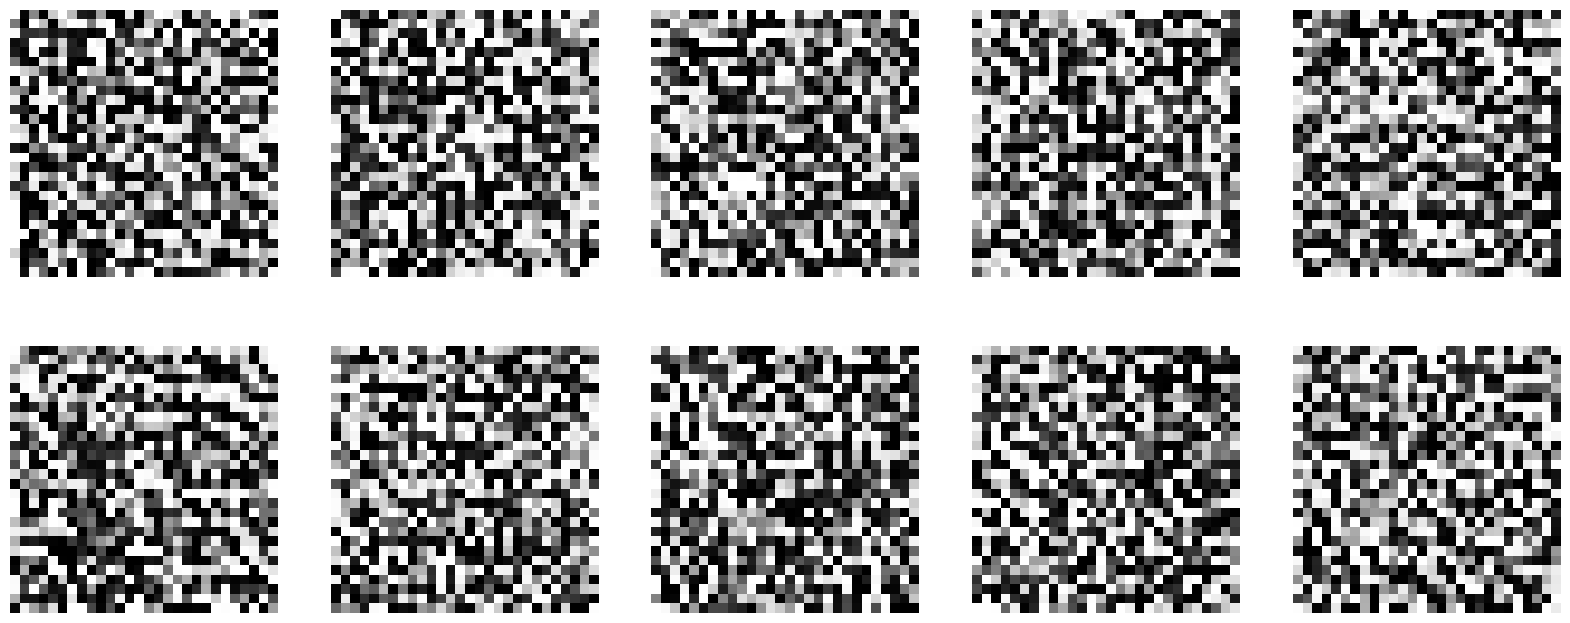

In [26]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(images[i], cmap='gray')
    ax[i // 5, i % 5].axis('off')

### Train the model

So that was obviously terrible... Let's train the model for a few epochs and see how it improves.

In [28]:
from tqdm import tqdm

for epoch in range(3):
    model.train()
    for i, (clean_images, labels) in tqdm(enumerate(train_loader)):
        noise = torch.randn(clean_images.shape)
        bs = clean_images.shape[0]
        labels = labels

        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps, labels, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    
    print(f'Epoch {epoch} Loss: {loss.item()}')


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
1875it [02:29, 12.52it/s]


Epoch 0 Loss: 0.05573713406920433


1875it [02:11, 14.20it/s]


Epoch 1 Loss: 0.04167181998491287


1875it [02:11, 14.24it/s]

Epoch 2 Loss: 0.05274556949734688


Now let's try sampling again...

In [29]:
images = sample(model=model,
                   scheduler=noise_scheduler,
                   batch_size=10,
                   generator=torch.manual_seed(1337),
                   num_inference_steps=200,
                   label=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

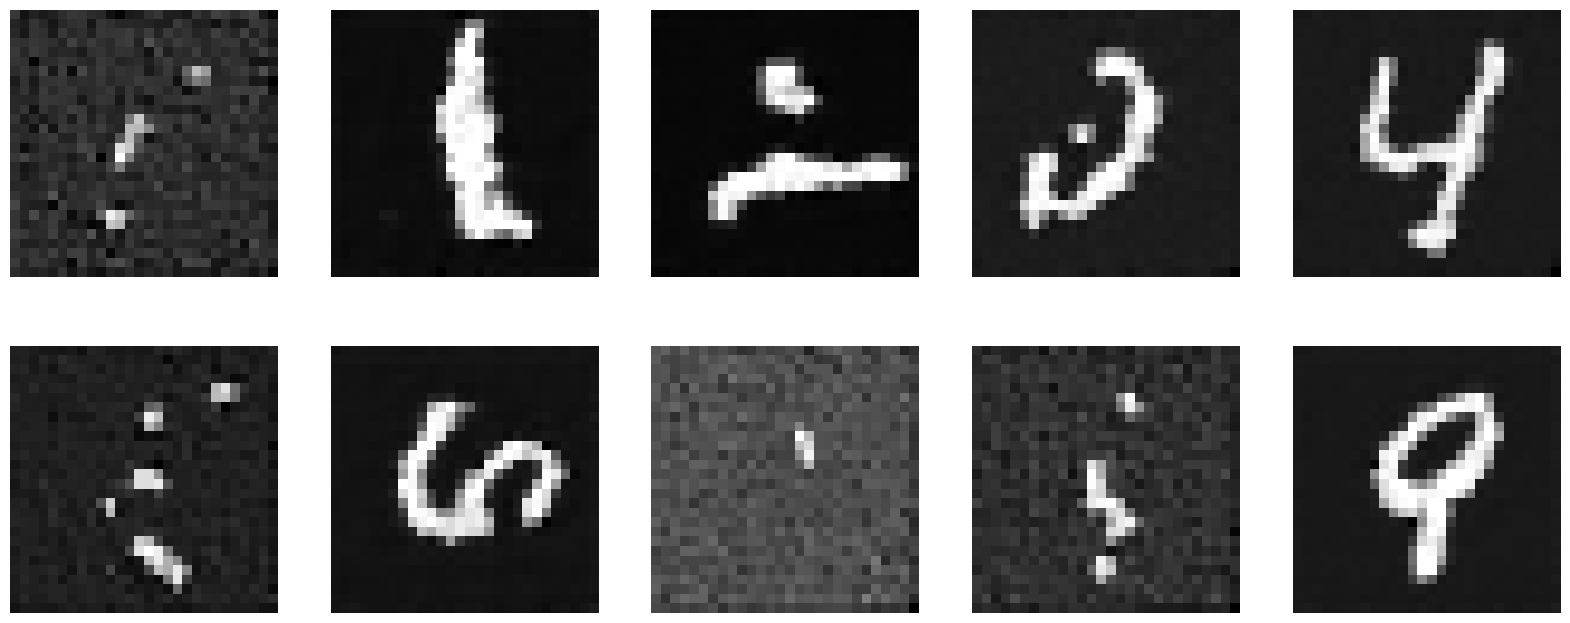

In [30]:
# show images

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(images[i], cmap='gray')
    ax[i // 5, i % 5].axis('off')

The model is definitely trying... The 1, 4 and 9 are pretty clear, but the 0, 5, 7, and 8 in particular are atrocious! Let's increase the number of layers per block and the size of the blocks to see if we can get some better results.

In [3]:
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=(8, 16, 32),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    num_class_embeds=10,
    norm_num_groups=2,
)

In [4]:
noise_scheduler = DDPMScheduler(num_train_timesteps=200)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_train_steps = len(train_loader) * 5

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=(num_train_steps),
)

In [5]:
from tqdm import tqdm

for epoch in range(5):
    model.train()
    for i, (clean_images, labels) in tqdm(enumerate(train_loader)):
        noise = torch.randn(clean_images.shape)
        bs = clean_images.shape[0]
        labels = labels

        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps, labels, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    
    print(f'Epoch {epoch} Loss: {loss.item()}')

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
1875it [05:13,  5.98it/s]


Epoch 0 Loss: 0.05497313663363457


1875it [05:28,  5.71it/s]


Epoch 1 Loss: 0.03213882073760033


1875it [04:57,  6.30it/s]


Epoch 2 Loss: 0.033250607550144196


1875it [04:53,  6.38it/s]


Epoch 3 Loss: 0.031056445091962814


1875it [04:51,  6.44it/s]

Epoch 4 Loss: 0.03150348365306854


In [ ]:
# save model and scheduler
torch.save(model.state_dict(), 'model.pth')

In [19]:
images = sample(model=model,
                   scheduler=noise_scheduler,
                   batch_size=10,
                   generator=torch.manual_seed(1337),
                   num_inference_steps=200,
                   label=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

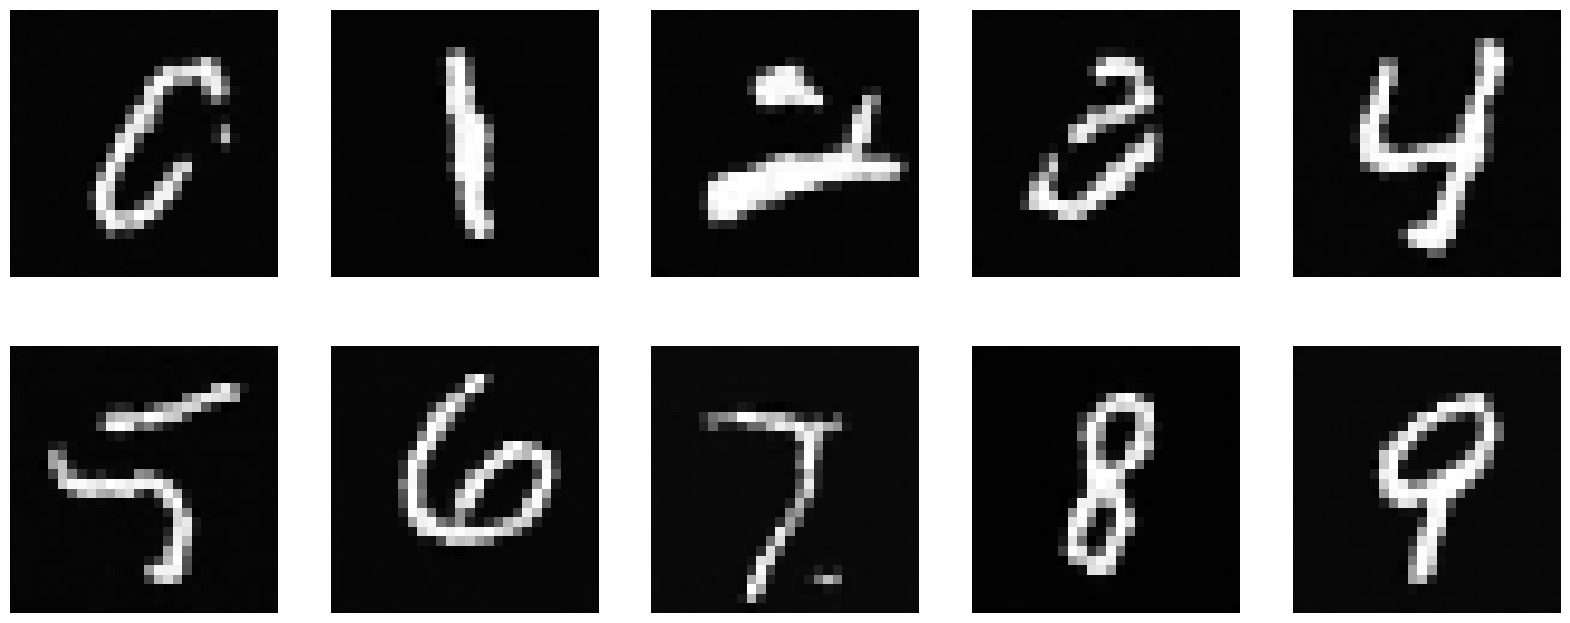

: 

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax[i // 5, i % 5].imshow(images[i], cmap='gray')
    ax[i // 5, i % 5].axis('off')

That is significantly better! Just think about what we've managed to do here. We've trained a model to generate MNIST digits using only a CPU! This is a testament to the power of the `diffusers` library and the incredible work that the Hugging Face team has done to make it accessible to everyone. Having said that, these images are tiny in comparison to many images used in research today. In order to generate larger images, we would need to use a GPU.